The following is a collaborative machine learning project conducted by Kinzie Bailey and Andrew Lomeli

### Imports ###

In [1]:
import os

%matplotlib inline
import string
import sys
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

#Import models from scikit learn module:
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import metrics
from sklearn.metrics import plot_roc_curve, plot_confusion_matrix
from sklearn.preprocessing import OrdinalEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC

# Import a resampler
from sklearn.utils import resample

# Import functions from other modules
from feature_engine.imputation import CategoricalImputer

### Reading in the data ###

In [2]:
df = pd.read_csv("stroke.csv", header=0) #Create pandas dataframe

In [3]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


### Data Preprocessing ###

In [4]:
df = df.drop(columns="id")
#Drop the ID column, as we know it is completely arbitrary and should not be used for predictions
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [5]:
df_rep = df['smoking_status'].replace('Unknown', np.nan)

df['smoking_status'] = df_rep

df.isnull().sum()

gender                  0
age                     0
hypertension            0
heart_disease           0
ever_married            0
work_type               0
Residence_type          0
avg_glucose_level       0
bmi                   201
smoking_status       1544
stroke                  0
dtype: int64

The "smoking_status" category has a data handle titled "Unknown", for consistency, we´ll be treating that as a null value

In [6]:
df.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     3566 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 439.3+ KB


We notice from this that both the bmi and smoking_status columns does contain null values, so imputation will be necessary. Our target column is the stroke column, which appears to be ordered from all True values to all False values. Since we have no reason to assume that BMI, a frequently skewed statistic, should be normally distributed in this dataset, we will be utilizing a "median" strategy for imputation.

We notice binary columns hypertension and heart_disease in the context of this dataset.

Some columns may need to be removed for relevance, such as ever_married, which represents too broad a range of possible context for a binary classification to provide meaningful data that we would want influencing the model's decisions. 

 Age makes prime target columns for binning. 

### Exploratory Data Analysis ###




Let's start by visualizing our features: 

([<matplotlib.axis.XTick at 0x27b4befe040>,
 [Text(1, 0, 'stroke'), Text(0, 0, 'no_stroke')])

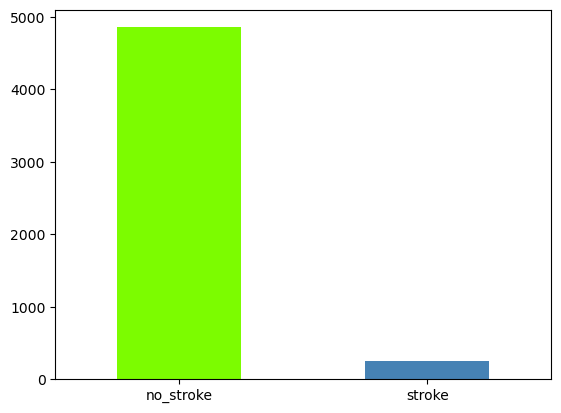

In [8]:
stroke_plot = df['stroke'].value_counts().plot(kind="bar", color=["lawngreen", "steelblue"], rot=0)
plt.xticks(ticks=[1,0], labels=["stroke", "no_stroke"])

The dataset appears to be heavily imablanced, with approximately 95% of all target column values being 0 (no-stroke). This makes sense, as strokes are a (mercifully) rare event, but it presents difficulties for analysis. 

Text(0, 0.5, 'Frequency')

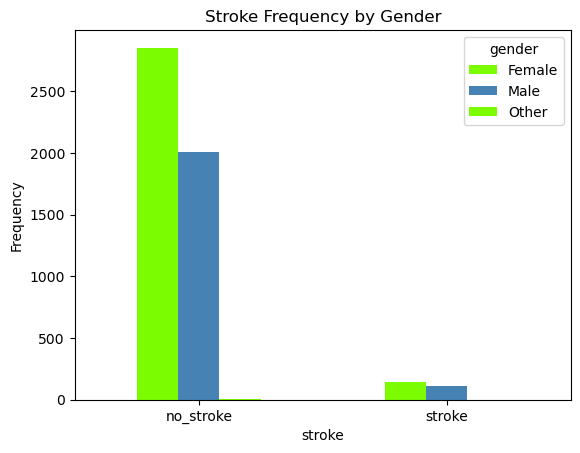

In [9]:
# The easiest feature to start with is "gender", so we'll start there

pd.crosstab(df.stroke, df.gender).plot(kind="bar",
                                       color=["lawngreen", "steelblue"],
                                       rot=0)

plt.title("Stroke Frequency by Gender")
plt.xticks(ticks=[1,0], labels=["stroke", "no_stroke"])
plt.ylabel("Frequency")

Text(0.5, 0, 'Age')

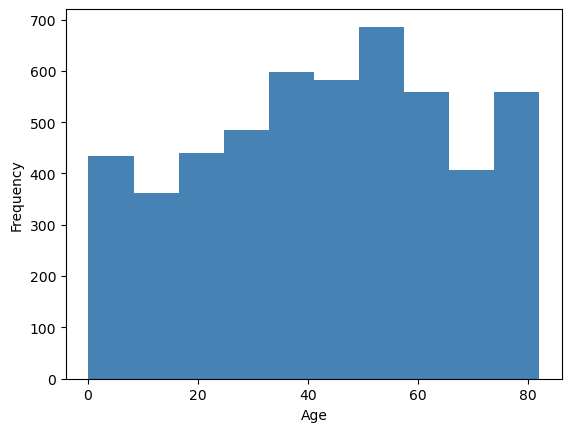

In [10]:
df["age"].plot.hist(color="steelblue")
plt.xlabel("Age")

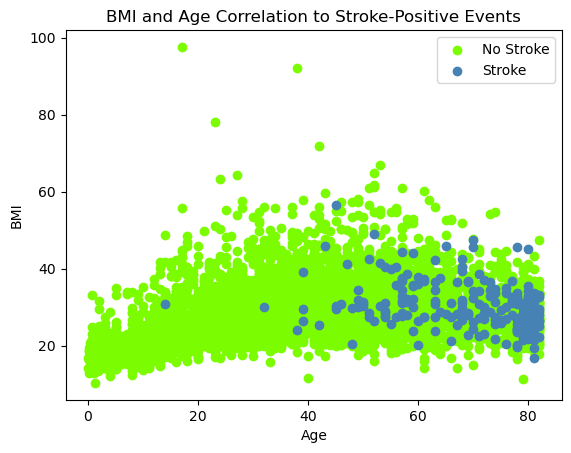

In [11]:
# We'll then try to take a look at the relationship between 2 important features and their correlation to stroke-positive events, BMI and age

plt.scatter(df.age[df.stroke==0],
            df.bmi[df.stroke==0],
            c = "lawngreen")

plt.scatter(df.age[df.stroke==1],
            df.bmi[df.stroke==1],
            c = "steelblue")


plt.title("BMI and Age Correlation to Stroke-Positive Events")
plt.xlabel("Age")
plt.ylabel("BMI")
plt.legend(["No Stroke", "Stroke"])

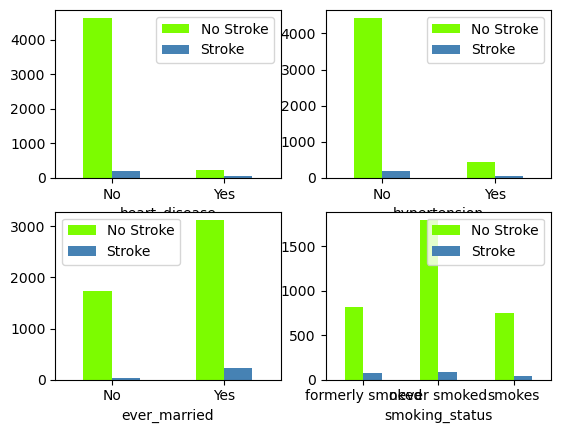

In [12]:
# Let's analyze the remaining features as a crosstab, for practicity's sake

cross_tab1 = pd.crosstab(df.heart_disease, df.stroke)
cross_tab2 = pd.crosstab(df.hypertension, df.stroke)
cross_tab3 = pd.crosstab(df.ever_married, df.stroke)
cross_tab4 = pd.crosstab(df.smoking_status, df.stroke)

colors = ["lawngreen", "steelblue"]

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2,
                                             ncols=2)

cross_tab1.plot(kind="bar", ax=ax1, color=colors, rot=0)
cross_tab2.plot(kind="bar", ax=ax2, color=colors, rot=0)
cross_tab3.plot(kind="bar", ax=ax3, color=colors, rot=0)
cross_tab4.plot(kind="bar", ax=ax4, color=colors, rot=0)

ax1.set_xticklabels(["No", "Yes"])
ax2.set_xticklabels(["No", "Yes"])

ax1.legend(["No Stroke", "Stroke"])
ax2.legend(["No Stroke", "Stroke"])
ax3.legend(["No Stroke", "Stroke"])
ax4.legend(["No Stroke", "Stroke"])

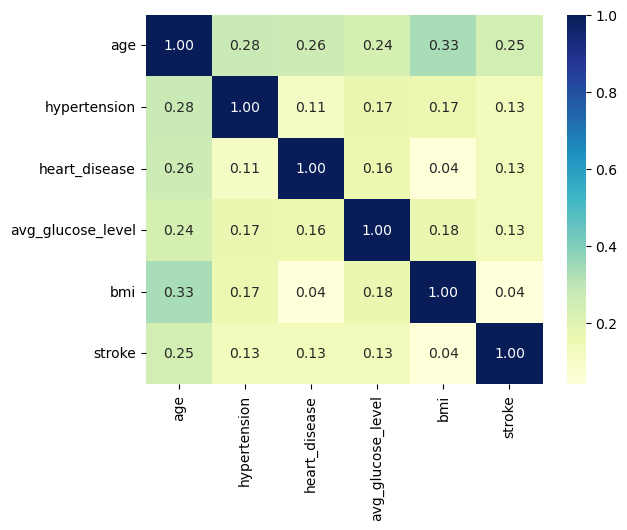

In [13]:
# Finally, let's take a look at a corralation matrix to see if there's any more information to infer. We'll visualize it as a heatmap for practicity's sake

correlation_matrix = df.corr()
fig, ax = plt.subplots()
ax = sns.heatmap(correlation_matrix,
                 annot=True,
                 fmt=".2f",
                 cmap="YlGnBu")

The strongest observable correlation to stroke occurance is with age, and it's not a very strong one at that (0.25). This is likely due to the fact that age is still not binned. 

### Data Modeling ### 



Here we will begin modeling our data for runs of analysis to occur in a few separate ways. To begin, we will drop our "ever_married" column, bin our "age" column, and create a "df_orig" object to reset our dataframe down the line.

In [14]:
df = df.drop(columns="ever_married")

In [15]:
bins = [0, 10, 20, 30, 40, 50, 60, 70, 83]
group_names = ['0-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-83']
age_bin = pd.cut(df['age'], bins, labels=group_names)
df['age_bin'] = pd.cut(df['age'], bins, labels=group_names)
df=pd.get_dummies(df, columns=['age_bin'])
df = df.drop(columns="age")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   hypertension       5110 non-null   int64  
 2   heart_disease      5110 non-null   int64  
 3   work_type          5110 non-null   object 
 4   Residence_type     5110 non-null   object 
 5   avg_glucose_level  5110 non-null   float64
 6   bmi                4909 non-null   float64
 7   smoking_status     3566 non-null   object 
 8   stroke             5110 non-null   int64  
 9   age_bin_0-10       5110 non-null   uint8  
 10  age_bin_11-20      5110 non-null   uint8  
 11  age_bin_21-30      5110 non-null   uint8  
 12  age_bin_31-40      5110 non-null   uint8  
 13  age_bin_41-50      5110 non-null   uint8  
 14  age_bin_51-60      5110 non-null   uint8  
 15  age_bin_61-70      5110 non-null   uint8  
 16  age_bin_71-83      5110 

In [16]:
df_orig = df

In [17]:
df.describe()

,hypertension,heart_disease,avg_glucose_level,bmi,stroke,age_bin_0-10,age_bin_11-20,age_bin_21-30,age_bin_31-40,age_bin_41-50,age_bin_51-60,age_bin_61-70,age_bin_71-83
count,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000
mean,0.097456,0.054012,106.147677,28.893237,0.048728,0.099217,0.101370,0.106654,0.131898,0.144618,0.161057,0.116243,0.138943
std,0.296607,0.226063,45.283560,7.854067,0.215320,0.298983,0.301847,0.308703,0.338413,0.351750,0.367619,0.320547,0.345921
min,0.000000,0.000000,55.120000,10.300000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,77.245000,23.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,91.885000,28.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,114.090000,33.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,271.740000,97.600000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


We see here that we still have missing values in our BMI column and our smoking status column (not displayed due to string data type). This will be remedied with imputation and ordinal encoding respectively 

In [18]:
X = df.drop("stroke", axis=1)
y = df["stroke"]

X.shape, y.shape

((5110, 16), (5110,))

In [19]:
# We need to create a random seed for the results to be consistently replicable (for grading purposes, we will be using '123')

np.random.seed(123)

# We then split the data into training and test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# We then need to further separate the training data into training and validation 

X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2)

Before building any models, we will utilize imputation to fill in our columns with missing data, namely "bmi" and "smoking_status". 

In [20]:
imputer_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
categorical_imputer = CategoricalImputer(imputation_method='frequent')

X_train['bmi'] = imputer_mean.fit_transform(X_train[['bmi']]).ravel()
X_validation['bmi'] = imputer_mean.transform(X_validation[['bmi']]).ravel()
X_test['bmi'] = imputer_mean.transform(X_test[['bmi']]).ravel()

X_train['smoking_status'] = categorical_imputer.fit_transform(X_train[['smoking_status']])
X_validation['smoking_status'] = categorical_imputer.transform(X_validation[['smoking_status']])
X_test['smoking_status'] = categorical_imputer.transform(X_test[['smoking_status']])

print(f"Number of null values in the training set: {X_train.isnull().sum()}")

print(f"Number of null values in the validation set: {X_validation.isnull().sum()}")

print(f"Number of null values in the test set: {X_test.isnull().sum()}")

Number of null values in the training set: gender               0
hypertension         0
heart_disease        0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
age_bin_0-10         0
age_bin_11-20        0
age_bin_21-30        0
age_bin_31-40        0
age_bin_41-50        0
age_bin_51-60        0
age_bin_61-70        0
age_bin_71-83        0
dtype: int64
Number of null values in the validation set: gender               0
hypertension         0
heart_disease        0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
age_bin_0-10         0
age_bin_11-20        0
age_bin_21-30        0
age_bin_31-40        0
age_bin_41-50        0
age_bin_51-60        0
age_bin_61-70        0
age_bin_71-83        0
dtype: int64
Number of null values in the test set: gender               0
hypertension         0
heart_disease        0
work_type            0
Residence_type     

In [21]:
print(f"Datatypes: {X_train.dtypes}")

print(f"Datatypes: {X_validation.dtypes}")

print(f"Datatypes: {X_test.dtypes}")

Datatypes: gender                object
hypertension           int64
heart_disease          int64
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
age_bin_0-10           uint8
age_bin_11-20          uint8
age_bin_21-30          uint8
age_bin_31-40          uint8
age_bin_41-50          uint8
age_bin_51-60          uint8
age_bin_61-70          uint8
age_bin_71-83          uint8
dtype: object
Datatypes: gender                object
hypertension           int64
heart_disease          int64
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
age_bin_0-10           uint8
age_bin_11-20          uint8
age_bin_21-30          uint8
age_bin_31-40          uint8
age_bin_41-50          uint8
age_bin_51-60          uint8
age_bin_61-70          uint8
age_bin_71-83          uint8
dtype: object
Datatypes: gender     

In [22]:
# Let's generate a list of variables that are objects so we can transform them and properly analyze them 

enc = OrdinalEncoder()

X_train[["work_type", "Residence_type", "gender", "smoking_status"]] = enc.fit_transform(X_train[["work_type", "Residence_type", "gender", "smoking_status"]])

X_test[["work_type", "Residence_type", "gender", "smoking_status"]] = enc.transform(X_test[["work_type", "Residence_type", "gender", "smoking_status"]])

X_validation[["work_type", "Residence_type", "gender", "smoking_status"]] = enc.transform(X_validation[["work_type", "Residence_type", "gender", "smoking_status"]])

In [23]:
# Let's make sure that the encoding worked properly

print(f"Datatypes: {X_train.dtypes}")

print(f"Datatypes: {X_validation.dtypes}")

print(f"Datatypes: {X_test.dtypes}")

Datatypes: gender               float64
hypertension           int64
heart_disease          int64
work_type            float64
Residence_type       float64
avg_glucose_level    float64
bmi                  float64
smoking_status       float64
age_bin_0-10           uint8
age_bin_11-20          uint8
age_bin_21-30          uint8
age_bin_31-40          uint8
age_bin_41-50          uint8
age_bin_51-60          uint8
age_bin_61-70          uint8
age_bin_71-83          uint8
dtype: object
Datatypes: gender               float64
hypertension           int64
heart_disease          int64
work_type            float64
Residence_type       float64
avg_glucose_level    float64
bmi                  float64
smoking_status       float64
age_bin_0-10           uint8
age_bin_11-20          uint8
age_bin_21-30          uint8
age_bin_31-40          uint8
age_bin_41-50          uint8
age_bin_51-60          uint8
age_bin_61-70          uint8
age_bin_71-83          uint8
dtype: object
Datatypes: gender     

We will attempt to work with 4 different estimators to model our data:

(1) Logistic Regression - which despite its name, is a linear model for classification

(2) Random Forest

(3) KNeighbors Classifier

(4) Linear SVC

We don't want to manually fit and score each of the models, so we will be utilizing the following function to fit and score each model. 

In [24]:
models = {"Logistic Regression" : LogisticRegression(),
          "Random Forest" : RandomForestClassifier(),
          "KNeighbors Classifier" : KNeighborsClassifier(),
          "Linear SVC" : LinearSVC()}

def fit_and_score_models(models, X_train, X_test, y_train, y_test):
    
    np.random.seed(123)

    model_scores = {}

    for name, model in models.items():

        model.fit(X_train, y_train)

        model_scores[name] = model.score(X_test, y_test)

    return model_scores


In [25]:
warnings.filterwarnings("ignore")

model_scores = fit_and_score_models(models, X_train, X_validation, y_train, y_validation)

model_scores

{'Logistic Regression': 0.9547677261613692,
 'Random Forest': 0.9486552567237164,
 'KNeighbors Classifier': 0.9547677261613692,
 'Linear SVC': 0.9547677261613692}

As we can see, each model did about as well as a DummyClassifier would do here. Interestingly, in this iteration, the KNeighbors Classifier did not perform the most poorly, doing as well as logistic regression, which is counter to our observations from previous runs that were done prior to trimming of irrelevant categorical features, where it performed poorly and influenced our decision to exclude it from further analysis. For the afformentioned reason, we will be excluding it here as well for consistency, but it is interesting nonetheless. 

### Hyperparameter Tuning ###





In [26]:
# For ease of visualization, we will place our hyperparameter values in different grids corresponding to each model

log_reg_grid = {"C" : np.logspace(-4,4,20),
                "penalty" : ["l1", "l2"],
                "solver" : ["liblinear", "lbfgs"]}

ran_for_grid = {"n_estimators" : np.arange(10,1000,50),
                "max_depth" : [None, 3, 5, 10],
                "min_samples_split" : np.arange(2,20,2)}

lin_svc_grid = {"C" : np.logspace(-3,3,7),
                "penalty" : ["l1", "l2"],
                "loss" : ["hinge", "squared_hinge", "modified_huber"]}

all_grids = [log_reg_grid, ran_for_grid, lin_svc_grid]

models = {"Logistic Regression" : [LogisticRegression(), log_reg_grid],
          "Random Forest" : [RandomForestClassifier(), ran_for_grid],
          "Linear SVC" : [LinearSVC(), lin_svc_grid]}

In [27]:
warnings.filterwarnings("ignore")

np.random.seed(123)

def random_tune (models, X_train, y_train):

    rs_models = {}

    for name, model in models.items():
        
        rs_model = RandomizedSearchCV(model[0],
                                      param_distributions=model[1],
                                      cv = 5,
                                      n_iter = 20,
                                      verbose = 0)
        rs_model.fit(X_train, y_train)
        rs_models[name] = rs_model

    return rs_models

rs_models = random_tune(models, X_train, y_train)

for name, model in rs_models.items():

    print(f"The best paramaters found for the {name} model are: \n{model.best_params_}")
    print(f"The score after using the best hyperparameters for the {name} model is: \n{model.score(X_validation, y_validation)}")
    print("__________________________")


The best paramaters found for the Logistic Regression model are: 
{'solver': 'liblinear', 'penalty': 'l1', 'C': 545.5594781168514}
The score after using the best hyperparameters for the Logistic Regression model is: 
0.9547677261613692
__________________________
The best paramaters found for the Random Forest model are: 
{'n_estimators': 760, 'min_samples_split': 12, 'max_depth': 10}
The score after using the best hyperparameters for the Random Forest model is: 
0.9547677261613692
__________________________
The best paramaters found for the Linear SVC model are: 
{'penalty': 'l2', 'loss': 'hinge', 'C': 1000.0}
The score after using the best hyperparameters for the Linear SVC model is: 
0.9547677261613692
__________________________


In [28]:
# Let's compare these scores with our baseline ones

print(" Baseline scores: ")
model_scores

 Baseline scores: 


{'Logistic Regression': 0.9547677261613692,
 'Random Forest': 0.9486552567237164,
 'KNeighbors Classifier': 0.9547677261613692,
 'Linear SVC': 0.9547677261613692}

"Baseline score" here refers to the score of a model on our dataset with no hyperparameter tuning. As we can see, hyperparameter tuning has minimal effect on the untrimmed data, as it doesn't matter much when the best option is to simply guess 0 every time.

We observe near identical scoring in each of our models here, so we will utilize linear SVC as our model to plot a confusion matrix and a ROC curve. In this run, since hyperparameter tuning didn't produce significant improvement, we will ignore it for now. 

In [29]:

clf = LinearSVC()

clf.fit(X_train, y_train)

clf.score(X_test, y_test)

0.9510763209393346

In [30]:
y_pred = clf.predict(X_test)

y_pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

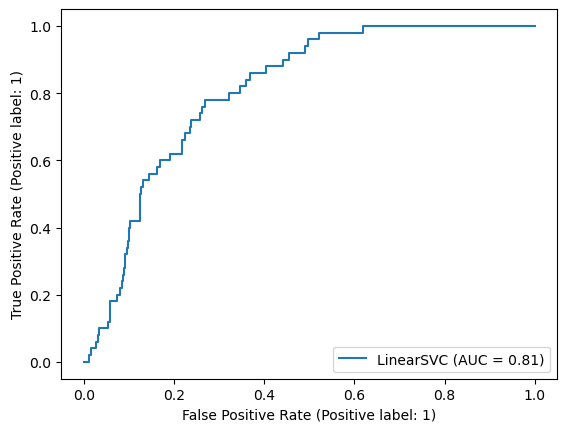

In [31]:
plot_roc_curve(clf, X_test, y_test)

The ROC curve and the AUC here seem to be deceptively good. A 0.81 value seemingly indicates that the model is able to predict more True Positives and Negatives than false ones. Due to how heavily imbalanced the dataset is, however, we'll opt for an additional metric to verify and justify our model's performance. 

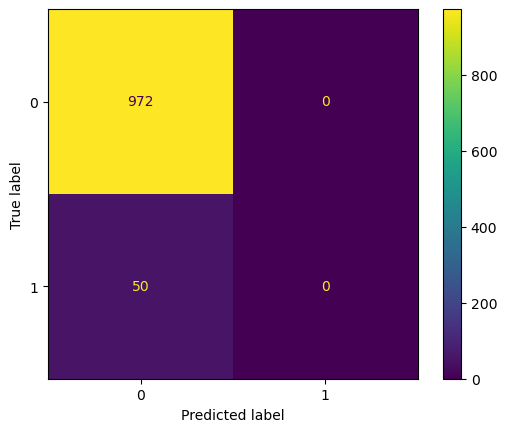

In [32]:
plot_confusion_matrix(clf, X_test, y_test)

As we can see by the confusion matrix, the results are far from ideal. As we predicted, the model made every single guess a "no stroke" event and still managed to get a 95% accuracy score. 

In [33]:
clf.coef_

array([[-0.0434549 ,  0.12694779,  0.04609615,  0.00386687,  0.00884988,
        -0.00088441,  0.00451698, -0.01832466, -0.1785834 , -0.19755833,
        -0.20248687, -0.14569713, -0.1227527 , -0.07929069, -0.06048404,
         0.15146495]])

In [34]:
# The previous results aren't really interpretable, so we'll map them to their correspoding columns
dlf = df.drop(columns="stroke")
feature_importance = dict(zip(dlf.columns, list(clf.coef_[0])))
feature_importance

{'gender': -0.04345489835853546,
 'hypertension': 0.12694778966172043,
 'heart_disease': 0.04609615109376618,
 'work_type': 0.0038668729130626363,
 'Residence_type': 0.0088498803892214,
 'avg_glucose_level': -0.0008844124745128294,
 'bmi': 0.004516978516649772,
 'smoking_status': -0.018324664282855254,
 'age_bin_0-10': -0.17858340032743955,
 'age_bin_11-20': -0.19755832710329177,
 'age_bin_21-30': -0.20248686976515015,
 'age_bin_31-40': -0.14569713411214982,
 'age_bin_41-50': -0.12275270499212074,
 'age_bin_51-60': -0.0792906934244274,
 'age_bin_61-70': -0.06048404386576851,
 'age_bin_71-83': 0.15146494550062795}

<AxesSubplot:title={'center':'Feature Importance'}>

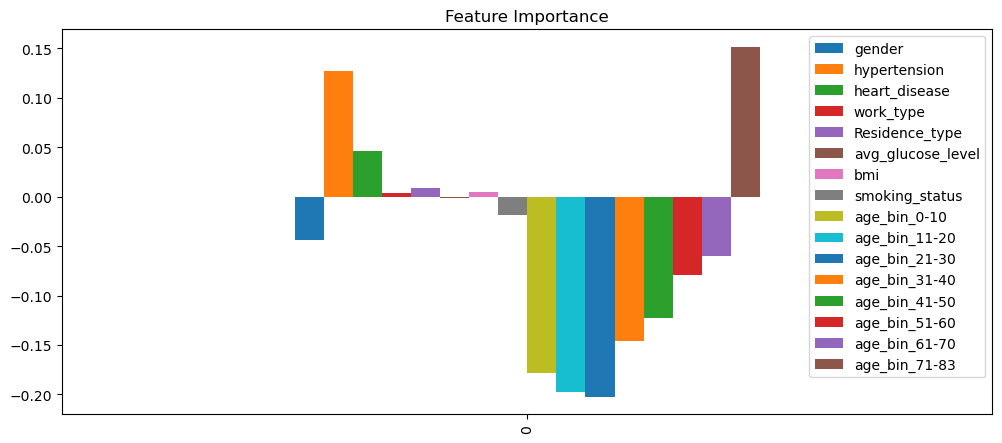

In [35]:
# Let's plot a this information to better visualize it

feature_imp_plt1 = pd.DataFrame(feature_importance, index=[0])

feature_imp_plt1.plot.bar(title = "Feature Importance", figsize = (12, 5))

We see here that, for this model, age, hypertension, and being between 71 and 83 have the highest positive influence on the data and other age groups having the lowest influence. We will repeat the analysis on the dataset resampled in two ratios, a 1:4 and a 1:1 ratio of stroke:no-stroke samples respectively. Age columns from 

In [36]:
#Here we will resample to 1000 samples to make a 1:4 ratio

df_maj = df_orig[(df_orig['stroke'] == 0)]
df_min = df_orig[(df_orig['stroke']== 1)]

df_maj_downsort = resample(df_maj, replace=True, n_samples=1000, random_state=123)

df = pd.concat([df_maj_downsort, df_min])

df["stroke"].value_counts()

0    1000
1     249
Name: stroke, dtype: int64

In [37]:
X = df.drop("stroke", axis=1)
y = df["stroke"]

X.shape, y.shape

((1249, 16), (1249,))

In [38]:
# We need to create a random seed for the results to be consistently replicable

np.random.seed(123)

# We then split the data into training and test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# We then need to further separate the training data into training and validation 

X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2)

Next, we will impute our data: 

In [39]:
imputer_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
categorical_imputer = CategoricalImputer(imputation_method='frequent')

X_train['bmi'] = imputer_mean.fit_transform(X_train[['bmi']]).ravel()
X_validation['bmi'] = imputer_mean.transform(X_validation[['bmi']]).ravel()
X_test['bmi'] = imputer_mean.transform(X_test[['bmi']]).ravel()

X_train['smoking_status'] = categorical_imputer.fit_transform(X_train[['smoking_status']])
X_validation['smoking_status'] = categorical_imputer.transform(X_validation[['smoking_status']])
X_test['smoking_status'] = categorical_imputer.transform(X_test[['smoking_status']])

print(f"Number of null values in the training set: {X_train.isnull().sum()}")

print(f"Number of null values in the validation set: {X_validation.isnull().sum()}")

print(f"Number of null values in the test set: {X_test.isnull().sum()}")

Number of null values in the training set: gender               0
hypertension         0
heart_disease        0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
age_bin_0-10         0
age_bin_11-20        0
age_bin_21-30        0
age_bin_31-40        0
age_bin_41-50        0
age_bin_51-60        0
age_bin_61-70        0
age_bin_71-83        0
dtype: int64
Number of null values in the validation set: gender               0
hypertension         0
heart_disease        0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
age_bin_0-10         0
age_bin_11-20        0
age_bin_21-30        0
age_bin_31-40        0
age_bin_41-50        0
age_bin_51-60        0
age_bin_61-70        0
age_bin_71-83        0
dtype: int64
Number of null values in the test set: gender               0
hypertension         0
heart_disease        0
work_type            0
Residence_type     

Next, we will transform our data set: 

In [40]:
# Let's generate a list of variables that are objects so we can transform them and properly analyze them 

enc = OrdinalEncoder()

X_train[["work_type", "Residence_type", "gender", "smoking_status"]] = enc.fit_transform(X_train[["work_type", "Residence_type", "gender", "smoking_status"]])

X_test[["work_type", "Residence_type", "gender", "smoking_status"]] = enc.transform(X_test[["work_type", "Residence_type", "gender", "smoking_status"]])

X_validation[["work_type", "Residence_type", "gender", "smoking_status"]] = enc.transform(X_validation[["work_type", "Residence_type", "gender", "smoking_status"]])

Fitting and scoring each model before hyperparameter tuning: 

In [41]:
models = {"Logistic Regression" : LogisticRegression(),
          "Random Forest" : RandomForestClassifier(),
          "KNeighbors Classifier" : KNeighborsClassifier(),
          "Linear SVC" : LinearSVC()}

def fit_and_score_models(models, X_train, X_test, y_train, y_test):
    
    np.random.seed(123)

    model_scores = {}

    for name, model in models.items():

        model.fit(X_train, y_train)

        model_scores[name] = model.score(X_test, y_test)

    return model_scores

In [42]:
warnings.filterwarnings("ignore")

model_scores = fit_and_score_models(models, X_train, X_validation, y_train, y_validation)

model_scores


{'Logistic Regression': 0.79,
 'Random Forest': 0.835,
 'KNeighbors Classifier': 0.805,
 'Linear SVC': 0.815}

A dummy classifier here would achieve roughly 75% accuracy. The above scores being higher implies that our models are behaving with more computational effort and actually applicable results, despite scoring lower than our above models. Here, our Random Forest classifier exhibits the most accuracy. 

### Hyperparameter Tuning for 1:4 Ratio ###

In [43]:
# For ease of visualization, we will place our hyperparameter values in different grids corresponding to each model

log_reg_grid = {"C" : np.logspace(-4,4,20),
                "penalty" : ["l1", "l2"],
                "solver" : ["liblinear", "lbfgs"]}

ran_for_grid = {"n_estimators" : np.arange(10,1000,50),
                "max_depth" : [None, 3, 5, 10],
                "min_samples_split" : np.arange(2,20,2)}

lin_svc_grid = {"C" : np.logspace(-3,3,7),
                "penalty" : ["l1", "l2"],
                "loss" : ["hinge", "squared_hinge", "modified_huber"]}

all_grids = [log_reg_grid, ran_for_grid, lin_svc_grid]

models = {"Logistic Regression" : [LogisticRegression(), log_reg_grid],
          "Random Forest" : [RandomForestClassifier(), ran_for_grid],
          "Linear SVC" : [LinearSVC(), lin_svc_grid]}

In [44]:
warnings.filterwarnings("ignore")

np.random.seed(123)

def random_tune (models, X_train, y_train):

    rs_models = {}

    for name, model in models.items():
        
        rs_model = RandomizedSearchCV(model[0],
                                      param_distributions=model[1],
                                      cv = 5,
                                      n_iter = 20,
                                      verbose = 0)
        rs_model.fit(X_train, y_train)
        rs_models[name] = rs_model

    return rs_models

rs_models = random_tune(models, X_train, y_train)

for name, model in rs_models.items():

    print(f"The best paramaters found for the {name} model are: \n{model.best_params_}")
    print(f"The score after using the best hyperparameters for the {name} model is: \n{model.score(X_validation, y_validation)}")
    print("__________________________")


The best paramaters found for the Logistic Regression model are: 
{'solver': 'lbfgs', 'penalty': 'l2', 'C': 10000.0}
The score after using the best hyperparameters for the Logistic Regression model is: 
0.795
__________________________
The best paramaters found for the Random Forest model are: 
{'n_estimators': 960, 'min_samples_split': 14, 'max_depth': None}
The score after using the best hyperparameters for the Random Forest model is: 
0.835
__________________________
The best paramaters found for the Linear SVC model are: 
{'penalty': 'l2', 'loss': 'squared_hinge', 'C': 0.01}
The score after using the best hyperparameters for the Linear SVC model is: 
0.815
__________________________


In [45]:
print("Best scores: ")
model_scores

Best scores: 


{'Logistic Regression': 0.79,
 'Random Forest': 0.835,
 'KNeighbors Classifier': 0.805,
 'Linear SVC': 0.815}

### For the report: Confusion Matrix and ROC Curve of our Best Model ### 

In [46]:
clf = RandomForestClassifier(n_estimators=310, min_samples_split=2, max_depth=10)

clf.fit(X_train, y_train)

clf.score(X_test, y_test)

0.804

We see an approximate 5% improvement over baseline expected score here(75% with DummyClassifier). 

In [47]:

y_pred = clf.predict(X_test)

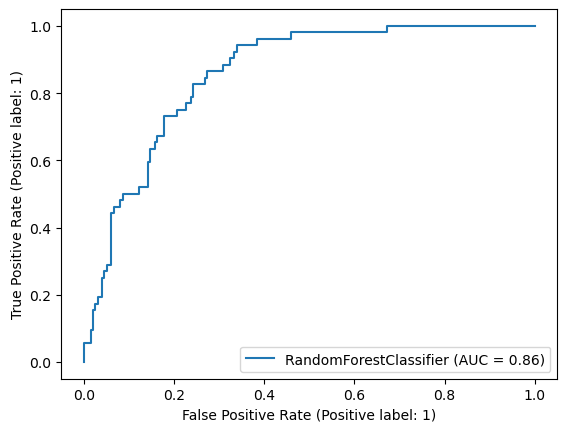

In [48]:
plot_roc_curve(clf, X_test, y_test)

In this ROC curve, we can see a slightly better AUC score than with the dataset without resampling, this being 0.86. While a score above 0.5 would indicate that the model is able to predict more True Positive and Negative cases than false ones, as we observed last time due to how imbalanced the dataset we're working with is we'll need additional verification of the model's performance. 

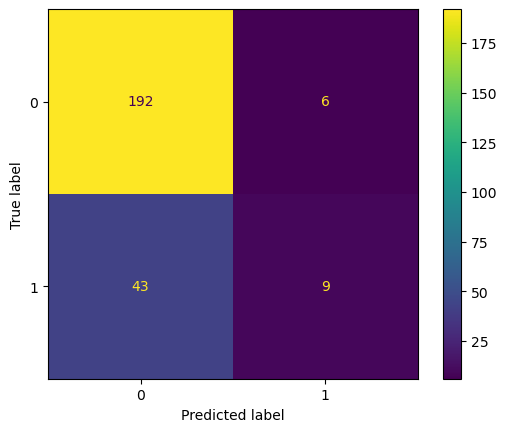

In [49]:
plot_confusion_matrix(clf, X_test, y_test)

This confusion matrix looks a lot better than the last one. While a lot of the predictions are still negative (and mostly correct), this model actually predicted some positive cases, and was correct most of the times. While far from perfect, this is most definately an improvement and a way more representative model than the one obtained without any resampling. 

To analyze feature importance, we will utilize default SVC as we did above for the sake of consistency

In [50]:
clf = LinearSVC()

clf.fit(X_train, y_train)

clf.score(X_test, y_test)

0.8

In [51]:
y_pred = clf.predict(X_test)
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0], dtype=int64)

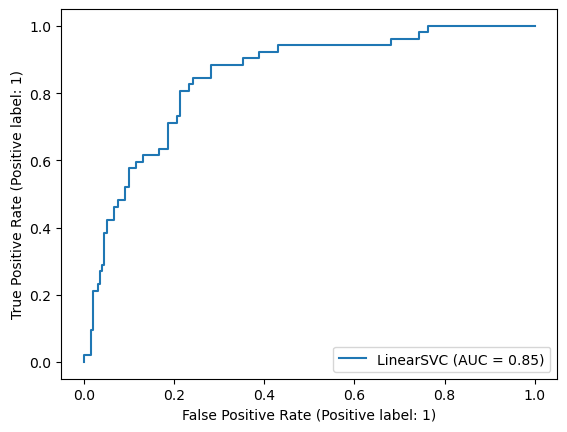

In [52]:
plot_roc_curve(clf, X_test, y_test)

The ROC curve obtained by using the Linear SVC model is almost identical to the one we obtained for the Random Forest Classifier, being different by only 0.01 in the AUC score. 

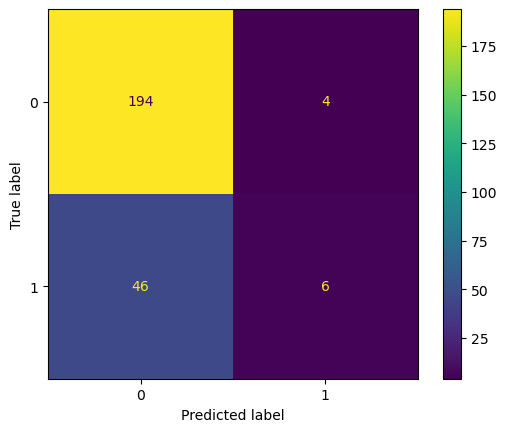

In [53]:
plot_confusion_matrix(clf, X_test, y_test)

The Linear SVC's performance is pretty much on-par with the random forest, which is to be expected due to how closely their respective scores are. 

In [54]:
dlf = df.drop(columns="stroke")
feature_importance = dict(zip(dlf.columns, list(clf.coef_[0])))
feature_importance

{'gender': -0.10522089088722156,
 'hypertension': 0.16144157160701889,
 'heart_disease': 0.3396531915720522,
 'work_type': 0.05161508169902781,
 'Residence_type': 0.07333688707172936,
 'avg_glucose_level': -0.0005889610982331474,
 'bmi': -0.0029174289980490225,
 'smoking_status': -0.05707807552194366,
 'age_bin_0-10': -0.4417649762782872,
 'age_bin_11-20': -0.2972824015289844,
 'age_bin_21-30': -0.36554311889089797,
 'age_bin_31-40': -0.13973206257689647,
 'age_bin_41-50': -0.13456264769245854,
 'age_bin_51-60': 0.02973240323463621,
 'age_bin_61-70': 0.18592831669174192,
 'age_bin_71-83': 0.5155192667385524}

<AxesSubplot:title={'center':'Feature Importance'}>

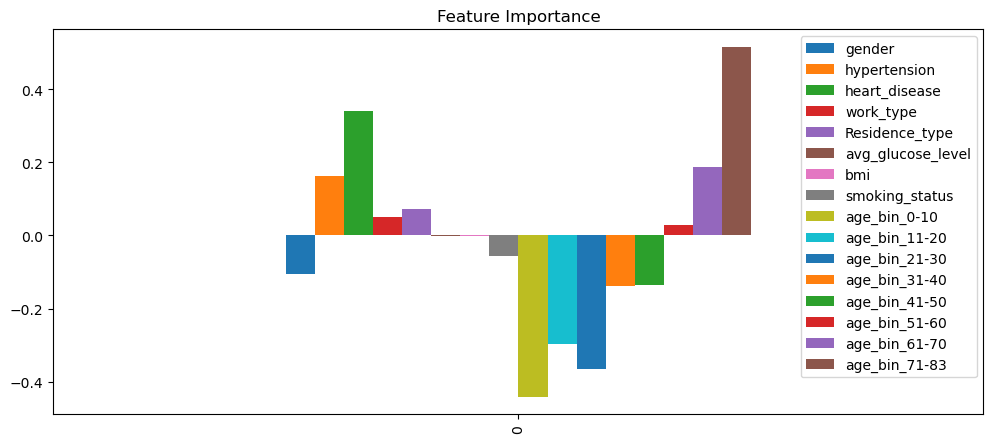

In [55]:
# Let's plot a this information to better visualize it

feature_imp_plt1 = pd.DataFrame(feature_importance, index=[0])

feature_imp_plt1.plot.bar(title = "Feature Importance", figsize = (12, 5))

We see here that the range of positively predictive ages increases. Age remains overall the most important predictor, with heart disease and hypertension being second and third most important toward the models classifications. We will now procede to run the analysis one more time, at a 1:1 ratio. 

In [56]:
#Here we will resample to 249 samples to make a 1:1 ratio

df_maj = df_orig[(df_orig['stroke'] == 0)]
df_min = df_orig[(df_orig['stroke']== 1)]

df_maj_downsort = resample(df_maj, replace=True, n_samples=249, random_state=123)

df = pd.concat([df_maj_downsort, df_min])

df["stroke"].value_counts()

0    249
1    249
Name: stroke, dtype: int64

In [57]:
X = df.drop("stroke", axis=1)
y = df["stroke"]

X.shape, y.shape

((498, 16), (498,))

In [58]:
# We need to create a random seed for the results to be consistently replicable

np.random.seed(123)

# We then split the data into training and test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# We then need to further separate the training data into training and validation 

X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2)

Imputation and Ordinal Encoding:

In [59]:
imputer_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
categorical_imputer = CategoricalImputer(imputation_method='frequent')

X_train['bmi'] = imputer_mean.fit_transform(X_train[['bmi']]).ravel()
X_validation['bmi'] = imputer_mean.transform(X_validation[['bmi']]).ravel()
X_test['bmi'] = imputer_mean.transform(X_test[['bmi']]).ravel()

X_train['smoking_status'] = categorical_imputer.fit_transform(X_train[['smoking_status']])
X_validation['smoking_status'] = categorical_imputer.transform(X_validation[['smoking_status']])
X_test['smoking_status'] = categorical_imputer.transform(X_test[['smoking_status']])

print(f"Number of null values in the training set: {X_train.isnull().sum()}")

print(f"Number of null values in the validation set: {X_validation.isnull().sum()}")

print(f"Number of null values in the test set: {X_test.isnull().sum()}")


Number of null values in the training set: gender               0
hypertension         0
heart_disease        0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
age_bin_0-10         0
age_bin_11-20        0
age_bin_21-30        0
age_bin_31-40        0
age_bin_41-50        0
age_bin_51-60        0
age_bin_61-70        0
age_bin_71-83        0
dtype: int64
Number of null values in the validation set: gender               0
hypertension         0
heart_disease        0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
age_bin_0-10         0
age_bin_11-20        0
age_bin_21-30        0
age_bin_31-40        0
age_bin_41-50        0
age_bin_51-60        0
age_bin_61-70        0
age_bin_71-83        0
dtype: int64
Number of null values in the test set: gender               0
hypertension         0
heart_disease        0
work_type            0
Residence_type     

In [60]:
# Let's generate a list of variables that are objects so we can transform them and properly analyze them 

enc = OrdinalEncoder()

X_train[["work_type", "Residence_type", "gender", "smoking_status"]] = enc.fit_transform(X_train[["work_type", "Residence_type", "gender", "smoking_status"]])

X_test[["work_type", "Residence_type", "gender", "smoking_status"]] = enc.transform(X_test[["work_type", "Residence_type", "gender", "smoking_status"]])

X_validation[["work_type", "Residence_type", "gender", "smoking_status"]] = enc.transform(X_validation[["work_type", "Residence_type", "gender", "smoking_status"]])


### Data Modelling ###

In [61]:
models = {"Logistic Regression" : LogisticRegression(),
          "Random Forest" : RandomForestClassifier(),
          "KNeighbors Classifier" : KNeighborsClassifier(),
          "Linear SVC" : LinearSVC()}

def fit_and_score_models(models, X_train, X_test, y_train, y_test):
    
    np.random.seed(123)

    model_scores = {}

    for name, model in models.items():

        model.fit(X_train, y_train)

        model_scores[name] = model.score(X_test, y_test)

    return model_scores


In [62]:
warnings.filterwarnings("ignore")

model_scores = fit_and_score_models(models, X_train, X_validation, y_train, y_validation)

model_scores

{'Logistic Regression': 0.675,
 'Random Forest': 0.625,
 'KNeighbors Classifier': 0.5125,
 'Linear SVC': 0.625}

These scores are noticeably worse than the ones obtained by using the 1:4 ratio, but we'll perform hyperparameter optimization to see if we can bring them up

In [63]:
# For ease of visualization, we will place our hyperparameter values in different grids corresponding to each model

log_reg_grid = {"C" : np.logspace(-4,4,20),
                "penalty" : ["l1", "l2"],
                "solver" : ["liblinear", "lbfgs"]}

ran_for_grid = {"n_estimators" : np.arange(10,1000,50),
                "max_depth" : [None, 3, 5, 10],
                "min_samples_split" : np.arange(2,20,2)}

lin_svc_grid = {"C" : np.logspace(-3,3,7),
                "penalty" : ["l1", "l2"],
                "loss" : ["hinge", "squared_hinge", "modified_huber"]}

all_grids = [log_reg_grid, ran_for_grid, lin_svc_grid]

models = {"Logistic Regression" : [LogisticRegression(), log_reg_grid],
          "Random Forest" : [RandomForestClassifier(), ran_for_grid],
          "Linear SVC" : [LinearSVC(), lin_svc_grid]}

In [64]:
warnings.filterwarnings("ignore")

np.random.seed(123)

def random_tune (models, X_train, y_train):

    rs_models = {}

    for name, model in models.items():
        
        rs_model = RandomizedSearchCV(model[0],
                                      param_distributions=model[1],
                                      cv = 5,
                                      n_iter = 20,
                                      verbose = 0)
        rs_model.fit(X_train, y_train)
        rs_models[name] = rs_model

    return rs_models

rs_models = random_tune(models, X_train, y_train)

for name, model in rs_models.items():

    print(f"The best paramaters found for the {name} model are: \n{model.best_params_}")
    print(f"The score after using the best hyperparameters for the {name} model is: \n{model.score(X_validation, y_validation)}")
    print("__________________________")

The best paramaters found for the Logistic Regression model are: 
{'solver': 'lbfgs', 'penalty': 'l2', 'C': 0.08858667904100823}
The score after using the best hyperparameters for the Logistic Regression model is: 
0.6625
__________________________
The best paramaters found for the Random Forest model are: 
{'n_estimators': 60, 'min_samples_split': 10, 'max_depth': 3}
The score after using the best hyperparameters for the Random Forest model is: 
0.675
__________________________
The best paramaters found for the Linear SVC model are: 
{'penalty': 'l2', 'loss': 'squared_hinge', 'C': 0.01}
The score after using the best hyperparameters for the Linear SVC model is: 
0.65
__________________________


In [65]:
print("Best scores: ")
model_scores

Best scores: 


{'Logistic Regression': 0.675,
 'Random Forest': 0.625,
 'KNeighbors Classifier': 0.5125,
 'Linear SVC': 0.625}

We see here that our RandomForestClassifier with hyperparameter tuning led to the highest scoring model here. Each model, save for the KNeighbors Classifier, exhibited significant improvement over the distribution baseline (50%). For feature importance and model evaluation, we will be using default SVC for consistency's sake to examine the effect of undersampling on the analysis. 

In [66]:
clf = LinearSVC()

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

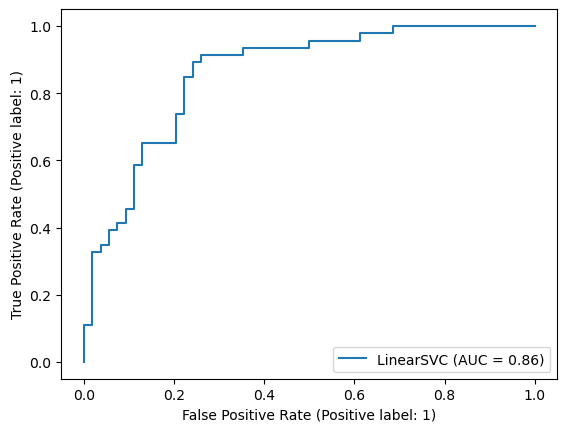

In [67]:
plot_roc_curve(clf, X_test, y_test) 

As was the case with the ROC curve obtained for the dataset without resampling, this plot is deceptive. An AUC score of 0.86 seemingly indicates a good model performance, but as we'll see exploring the confusion matrix, this is not exactly true. 

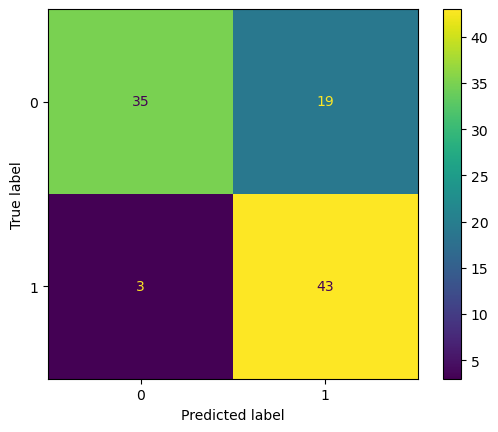

In [68]:
plot_confusion_matrix(clf, X_test, y_test)

Using a 1:1 ratio to make predictions, we can see that the model's performance is far from optimal. The number of both false positives and false negatives noticeably increased from the predictor models using a 1:4 ratio.

In [69]:
dlf = df.drop(columns="stroke")
feature_importance = dict(zip(dlf.columns, list(clf.coef_[0])))
feature_importance

{'gender': -0.11337912138126269,
 'hypertension': 0.2539570921426717,
 'heart_disease': 0.26321684705105275,
 'work_type': -0.12391227736364294,
 'Residence_type': 0.01899842953508771,
 'avg_glucose_level': 0.004801807021264225,
 'bmi': 0.004410496856559714,
 'smoking_status': -0.0959008564762148,
 'age_bin_0-10': -0.22592058899832512,
 'age_bin_11-20': -0.43222111691638554,
 'age_bin_21-30': -0.5359867083731474,
 'age_bin_31-40': -0.380713835722277,
 'age_bin_41-50': -0.10469493132866148,
 'age_bin_51-60': 0.06406499931013647,
 'age_bin_61-70': 0.4427725175728705,
 'age_bin_71-83': 0.9504097941729712}

<AxesSubplot:title={'center':'Feature Importance'}>

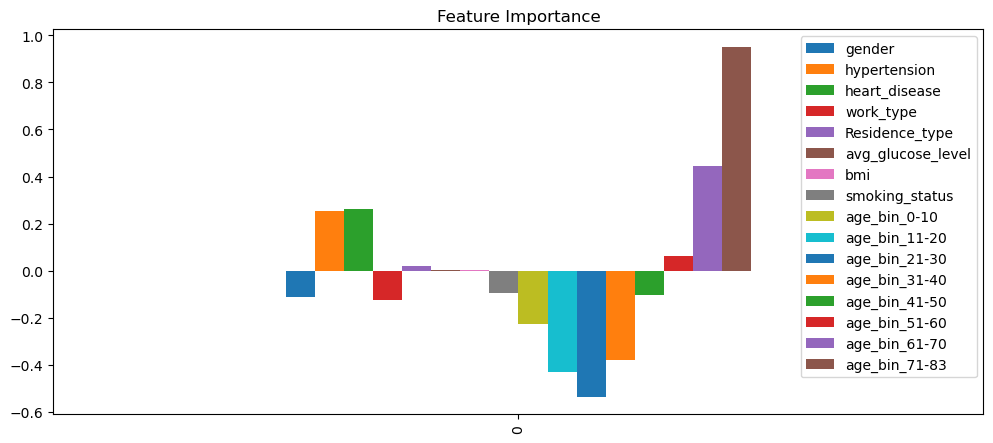

In [70]:
# Let's plot a this information to better visualize it

feature_imp_plt1 = pd.DataFrame(feature_importance, index=[0])

feature_imp_plt1.plot.bar(title = "Feature Importance", figsize = (12, 5))


We observe here a similar pattern to our 1:4 split, with hypertension and heart disease now being ranked as equally important and age remaining by far the most important predictive factor. 

### Conclusions: ### 

From our data, we observe that our best model was the RandomForestClassifier with tuned hyperparameters. We were able to generate a useful model despite an unbalanced dataset through resampling, imputation of missing values, binning age, and ordinal encoding of categorical features. In a real world setting, we would hope to utilize a different or expanded dataset to make predictions given the high unbalance in our own and the fact that trimming data is never preferable. Ideally, such data would include more positive (stroke == 1) samples in order to balance the data. While our 1:1 ratio produced models with increased accuracy over baseline, this failed to reach the accuracy of our RandomForestClassifier trained on 1249 samples, which also produced an improvement over a "most frequent" dummy classification strategy. 